# ANLI with LLM

You have to implement in this notebook a better ANLI classifier using an LLM.
This classifier must be implemented using DSPy.


In [ ]:
# Configure the DSPy environment with the language model - for grok the parameters must be:
# env variable should be in os.environ['XAI_API_KEY']
# "xai/grok-3-mini"
import os
import dspy
from typing import Literal
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import evaluate
import numpy as np
from tqdm.auto import tqdm


os.environ["XAI_API_KEY"] = ""

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
dspy.configure(lm=lm)

## Load ANLI dataset

In [3]:
dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [4]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [5]:
import evaluate
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

## Your Turn

Compute the classification metrics on the baseline LLM model on each test section of the ANLI dataset for samples that have a non-empty 'reason' field.

You also must show a comparison between the DeBERTa baseline model and this LLM baseline model. The comparison metric should compute the agreement between the two models:
* On how many samples they are both correct [Correct]
* On how many samples Model1 is correct and Model2 is incorrect [Correct1]
* On how many samples Model1 is incorrect and Model2 is correct [Correct2]
* On how many samples both are incorrect [Incorrect]

### DSPy Signatures and Modules 

In [6]:
class JointPromptSignature(dspy.Signature):
    """Generate both an explanation and a label for the NLI task in one step."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineExplanationSignature(dspy.Signature):
    """Generate an explanation for the relationship between premise and hypothesis."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis.")  

class PipelineResponseSignature(dspy.Signature):
    """Given an explanation, determine the entailment label."""
    premise = dspy.InputField()
    hypothesis = dspy.InputField()
    explanation = dspy.InputField(desc="Explanation of the relationship between premise and hypothesis.")
    label: Literal['entailment', 'neutral', 'contradiction'] = dspy.OutputField()

class PipelineModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.explanation_step = dspy.ChainOfThought(PipelineExplanationSignature)
        self.label_step = dspy.Predict(PipelineResponseSignature)
    
    def forward(self, premise, hypothesis):
        explanation_result = self.explanation_step(
            premise=premise, 
            hypothesis=hypothesis 
        )
        label_result = self.label_step(premise=premise, hypothesis=hypothesis, explanation=explanation_result.explanation)

        return dspy.Prediction(
            explanation=explanation_result.explanation,
            label=label_result.label
        )

# Initialize modules
print("Initializing modules...")
joint_cot = dspy.ChainOfThought(JointPromptSignature)
pipeline_module = PipelineModule()
print("✓ Modules initialized")



Initializing modules...
✓ Modules initialized


### Prepare Data for Evaluation

In [7]:
from typing import List, Dict, Any

def create_dspy_examples(dataset: List[Dict[str, Any]]) -> List[dspy.Example]:
    """
    Convert dataset to dspy.Example instances including the 'reason' field.
    The 'reason' field will be stored in the example but won't be visible to the LLM
    since it's not included in the signatures.
    """
    examples = []
    for item in dataset:
        if item.get('reason') and item['reason'].strip() != '':
            # Create dspy.Example with all fields including 'reason'
            example = dspy.Example(
                premise=item['premise'],
                hypothesis=item['hypothesis'],
                label=item['label'],
                reason=item['reason']
            ).with_inputs('premise', 'hypothesis')
            
            examples.append(example)
    return examples

In [8]:
# Load evaluation dataset (using dev_r3 for testing)
print("Loading dev_r3 dataset...")
dev_dataset = load_dataset("anli", split="dev_r3")
# Filter examples with reasons
dev_with_reasons = [ex for ex in dev_dataset if ex.get('reason') and ex['reason'].strip() != '']
print(f"Found {len(dev_with_reasons)} examples with reasons out of {len(dev_dataset)} total")

Loading dev_r3 dataset...
Found 1200 examples with reasons out of 1200 total


In [9]:
# Convert evaluation samples to dspy.Example instances
dspy_eval_samples = create_dspy_examples(dev_with_reasons)

# Create a mapping from (premise, hypothesis) to reason so we can access reason in refine module wihout passing it to the LLM
REASON_MAP = {}

for ex in dspy_eval_samples:
    if isinstance(ex, dict):
        key = (ex['premise'], ex['hypothesis'])
        REASON_MAP[key] = ex.get('reason', '')
    else:  # dspy.Example
        key = (ex.premise, ex.hypothesis)
        REASON_MAP[key] = ex.get('reason', '')

### Similarity Analysis

In [10]:
from sentence_transformers import SentenceTransformer
similarity_model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_similarity_scores(premise, hypothesis, human_reason, predicted_explanation):
    """
    Compute similarity scores between different text combinations.
    Returns a dictionary with all possible combinations.
    """
    # Combine premise and hypothesis
    premise_hypothesis = f"{premise} {hypothesis}"
    
    # Encode all texts
    texts = [premise_hypothesis, human_reason, predicted_explanation]
    embeddings = similarity_model.encode(texts)
    
    # Compute similarities
    similarities = similarity_model.similarity(embeddings, embeddings).numpy()
    
    # Extract individual similarities
    ph_hr_sim = similarities[0, 1]  # premise+hypothesis vs human_reason
    ph_pe_sim = similarities[0, 2]  # premise+hypothesis vs predicted_explanation
    hr_pe_sim = similarities[1, 2]  # human_reason vs predicted_explanation
    
    # Handle division by zero
    def safe_divide(a, b):
        return a / b if b != 0 else 0
    
    return {
        'A': ph_hr_sim,  # (premise, hypothesis) vs human_reason
        'B': hr_pe_sim,  # human_reason vs predicted_explanation
        'C': ph_pe_sim,  # (premise, hypothesis) vs predicted_explanation
        'A/B': safe_divide(ph_hr_sim, hr_pe_sim),
        'A/C': safe_divide(ph_hr_sim, ph_pe_sim),
        'B/C': safe_divide(hr_pe_sim, ph_pe_sim)
    }



In [12]:
def evaluate_with_similarity(module, dataset, collect_results=False):
    """
    Evaluate a module on the dataset and optionally collect detailed results.
    """

    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

    correct = 0
    total = 0
    results = []
    
    for example in tqdm(dataset, desc="Evaluating"):
        # Skip examples without human reason
        if not example.get('reason') or example['reason'].strip() == '':
            continue
            
        try:
            # Get prediction
            prediction = module(
                premise=example['premise'],
                hypothesis=example['hypothesis']
            )

            pred_label_str = prediction.label.lower().strip()
            pred_label_int = LABEL_MAP.get(pred_label_str, -1)

            # Check if prediction is correct
            is_correct = pred_label_int == example['label']

            if is_correct:
                correct += 1
            total += 1
            
            # Collect detailed results if requested
            if collect_results:
                # Compute similarity scores
                sim_scores = compute_similarity_scores(
                    premise=example['premise'],
                    hypothesis=example['hypothesis'],
                    human_reason=example['reason'],
                    predicted_explanation=prediction.explanation
                )
                
                results.append({
                    'premise': example['premise'],
                    'hypothesis': example['hypothesis'],
                    'true_label': example['label'],
                    'predicted_label': prediction.label,
                    'human_reason': example['reason'],
                    'predicted_explanation': prediction.explanation,
                    'is_correct': is_correct,
                    **sim_scores  # Add all similarity scores
                })
                
        except Exception as e:
            print(f"Error processing example: {e}")
            continue
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, results

In [13]:
def evaluate_with_similarity_v2(module, dataset, collect_results=False):

    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

    correct = 0
    total = 0
    results = []
    
    for example in tqdm(dataset, desc="Evaluating"):
        # Handle both dict and dspy.Example
        if isinstance(example, dict):
            premise = example['premise']
            hypothesis = example['hypothesis']
            reason = example.get('reason', '')
            true_label = example['label']
        else:  # dspy.Example
            premise = example.premise
            hypothesis = example.hypothesis
            reason = example.get('reason', '')
            true_label = example.label
            
        # Skip examples without human reason
        if not reason or reason.strip() == '':
            continue
            
        try:
            # Get prediction
            prediction = module(
                premise=premise,
                hypothesis=hypothesis
            )

            pred_label_str = prediction.label.lower().strip()
            pred_label_int = LABEL_MAP.get(pred_label_str, -1)

            # Check if prediction is correct
            is_correct = pred_label_int == true_label

            if is_correct:
                correct += 1
            total += 1
            
            # Collect detailed results if requested
            if collect_results:
                # Compute similarity scores
                sim_scores = compute_similarity_scores(
                    premise=premise,
                    hypothesis=hypothesis,
                    human_reason=reason,
                    predicted_explanation=prediction.explanation
                )
                
                results.append({
                    'premise': premise,
                    'hypothesis': hypothesis,
                    'true_label': true_label,
                    'predicted_label': prediction.label,
                    'human_reason': reason,
                    'predicted_explanation': prediction.explanation,
                    'is_correct': is_correct,
                    **sim_scores  # Add all similarity scores
                })
                
        except Exception as e:
            print(f"Error processing example: {e}")
            continue
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, results



In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def create_similarity_histograms(results, approach_name):
    """
    Create histograms for each similarity metric comparing correct vs incorrect predictions.
    """
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # Separate correct and incorrect predictions
    correct_df = df[df['is_correct'] == True]
    incorrect_df = df[df['is_correct'] == False]
    
    # Define metrics to plot
    metrics = ['A', 'B', 'C', 'A/B', 'A/C', 'B/C']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{approach_name} - Similarity Metrics Distribution: Correct vs Incorrect Predictions', fontsize=16)
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Get data for correct and incorrect predictions
        correct_values = correct_df[metric].values
        incorrect_values = incorrect_df[metric].values
        
        # Determine range for histogram bins
        all_values = np.concatenate([correct_values, incorrect_values])
        min_val, max_val = np.min(all_values), np.max(all_values)
        
        # Create bins
        if metric in ['A', 'B', 'C']:  # Similarity scores are between 0 and 1
            bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
        else:  # Ratio metrics can have wider range
            bins = np.linspace(min_val, max_val, 21)
        
        # Plot histograms
        ax.hist(correct_values, bins=bins, alpha=0.7, label='Correct', color='green', edgecolor='black')
        ax.hist(incorrect_values, bins=bins, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
        
        # Add labels and title
        ax.set_xlabel(f'{metric} Score')
        ax.set_ylabel('Count')
        ax.set_title(f'Metric {metric}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        correct_mean = np.mean(correct_values) if len(correct_values) > 0 else 0
        incorrect_mean = np.mean(incorrect_values) if len(incorrect_values) > 0 else 0
        ax.text(0.05, 0.95, f'Correct μ: {correct_mean:.3f}\nIncorrect μ: {incorrect_mean:.3f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

In [22]:
from dspy.evaluate import Evaluate

def create_evaluator_metric(module, collect_similarity=False):
    """Create a metric function compatible with dspy.Evaluate"""
    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    results_collector = [] if collect_similarity else None
    
    def metric(example, prediction, trace=None):
        # Handle the case where prediction might be the module output
        if hasattr(prediction, 'label'):
            pred_label = prediction.label
            pred_explanation = prediction.explanation
        else:
            # If not, run the module
            pred = module(premise=example.premise, hypothesis=example.hypothesis)
            pred_label = pred.label
            pred_explanation = pred.explanation
        
        # Convert labels
        pred_label_int = LABEL_MAP.get(pred_label.lower().strip(), -1)
        true_label = example.label
        
        is_correct = pred_label_int == true_label
        
        # Collect similarity scores if requested
        if collect_similarity and hasattr(example, 'reason') and example.reason:
            sim_scores = compute_similarity_scores(
                premise=example.premise,
                hypothesis=example.hypothesis,
                human_reason=example.reason,
                predicted_explanation=pred_explanation
            )
            results_collector.append({
                'premise': example.premise,
                'hypothesis': example.hypothesis,
                'true_label': true_label,
                'predicted_label': pred_label,
                'human_reason': example.reason,
                'predicted_explanation': pred_explanation,
                'is_correct': is_correct,
                **sim_scores
            })
        
        return is_correct
    
    return metric, results_collector

def evaluate_with_similarity_parallel(module, dataset, num_threads=4, collect_results=False):
    """
    Parallel evaluation using dspy.Evaluate while maintaining similarity analysis
    """
    # Create metric function and results collector
    metric_fn, results_collector = create_evaluator_metric(module, collect_results)
    
    # Filter dataset for examples with reasons
    filtered_dataset = []
    for ex in dataset:
        if isinstance(ex, dspy.Example) and hasattr(ex, 'reason') and ex.reason:
            filtered_dataset.append(ex)
        elif isinstance(ex, dict) and ex.get('reason'):
            # Convert dict to dspy.Example if needed
            filtered_dataset.append(dspy.Example(**ex).with_inputs('premise', 'hypothesis'))
    
    # Run parallel evaluation
    evaluator = Evaluate(
        devset=filtered_dataset,
        metric=metric_fn,
        num_threads=num_threads,
        display_progress=True,
        display_table=0
    )
    
    accuracy = evaluator(module)
    
    return accuracy, results_collector if collect_results else []


### Parallel Eval Method

In [25]:
joint_accuracy, joint_results = evaluate_with_similarity_parallel(
    joint_cot,
    dspy_eval_samples[:200],
    num_threads=4,  
    collect_results=True
)
print(f"Joint CoT Accuracy: {joint_accuracy:.3f}")

Average Metric: 147.00 / 200 (73.5%): 100%|██████████| 200/200 [00:53<00:00,  3.74it/s]

2025/08/03 13:44:21 INFO dspy.evaluate.evaluate: Average Metric: 147 / 200 (73.5%)



Joint CoT Accuracy: 73.500


In [26]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity_parallel(
    pipeline_module,
    dspy_eval_samples[:200],
    num_threads=4,  
    collect_results=True
)
print(f"Pipeline Module Accuracy: {pipeline_accuracy:.3f}")

Average Metric: 149.00 / 200 (74.5%): 100%|██████████| 200/200 [01:02<00:00,  3.18it/s]

2025/08/03 13:48:36 INFO dspy.evaluate.evaluate: Average Metric: 149 / 200 (74.5%)



Pipeline Module Accuracy: 74.500


In [ ]:
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()

### Old Evaluation 

In [ ]:
joint_accuracy, joint_results = evaluate_with_similarity(
    joint_cot, 
    dev_with_reasons[:200], 
    similarity_model,
    collect_results=True
)

In [ ]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity(
    pipeline_module,
    dev_with_reasons[:200],
    collect_results=True
)

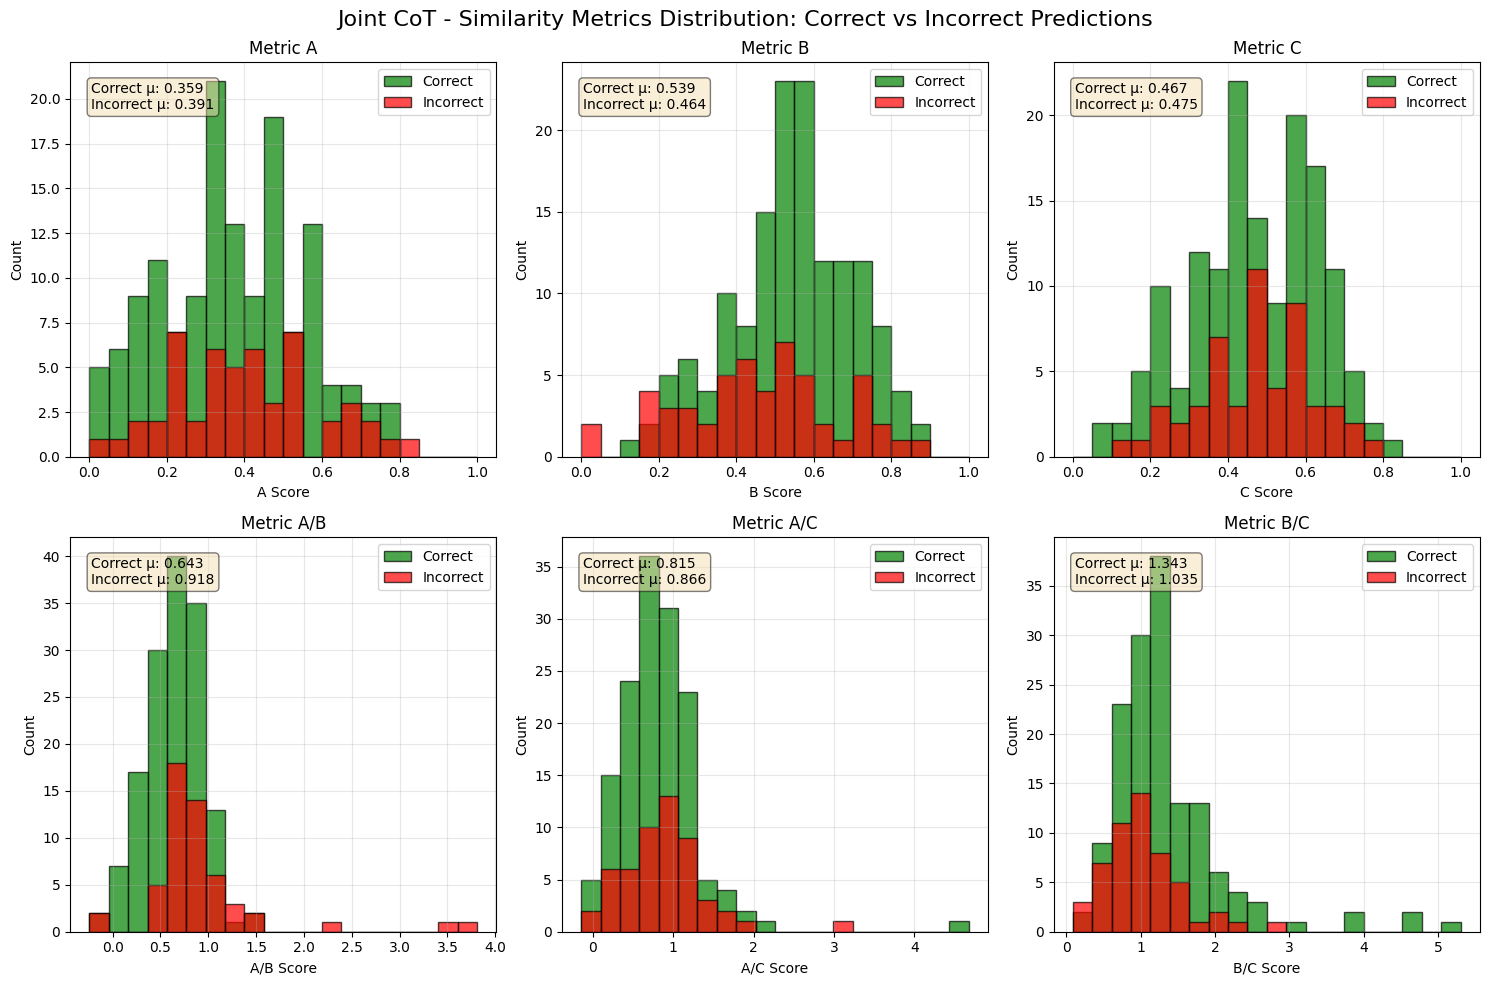

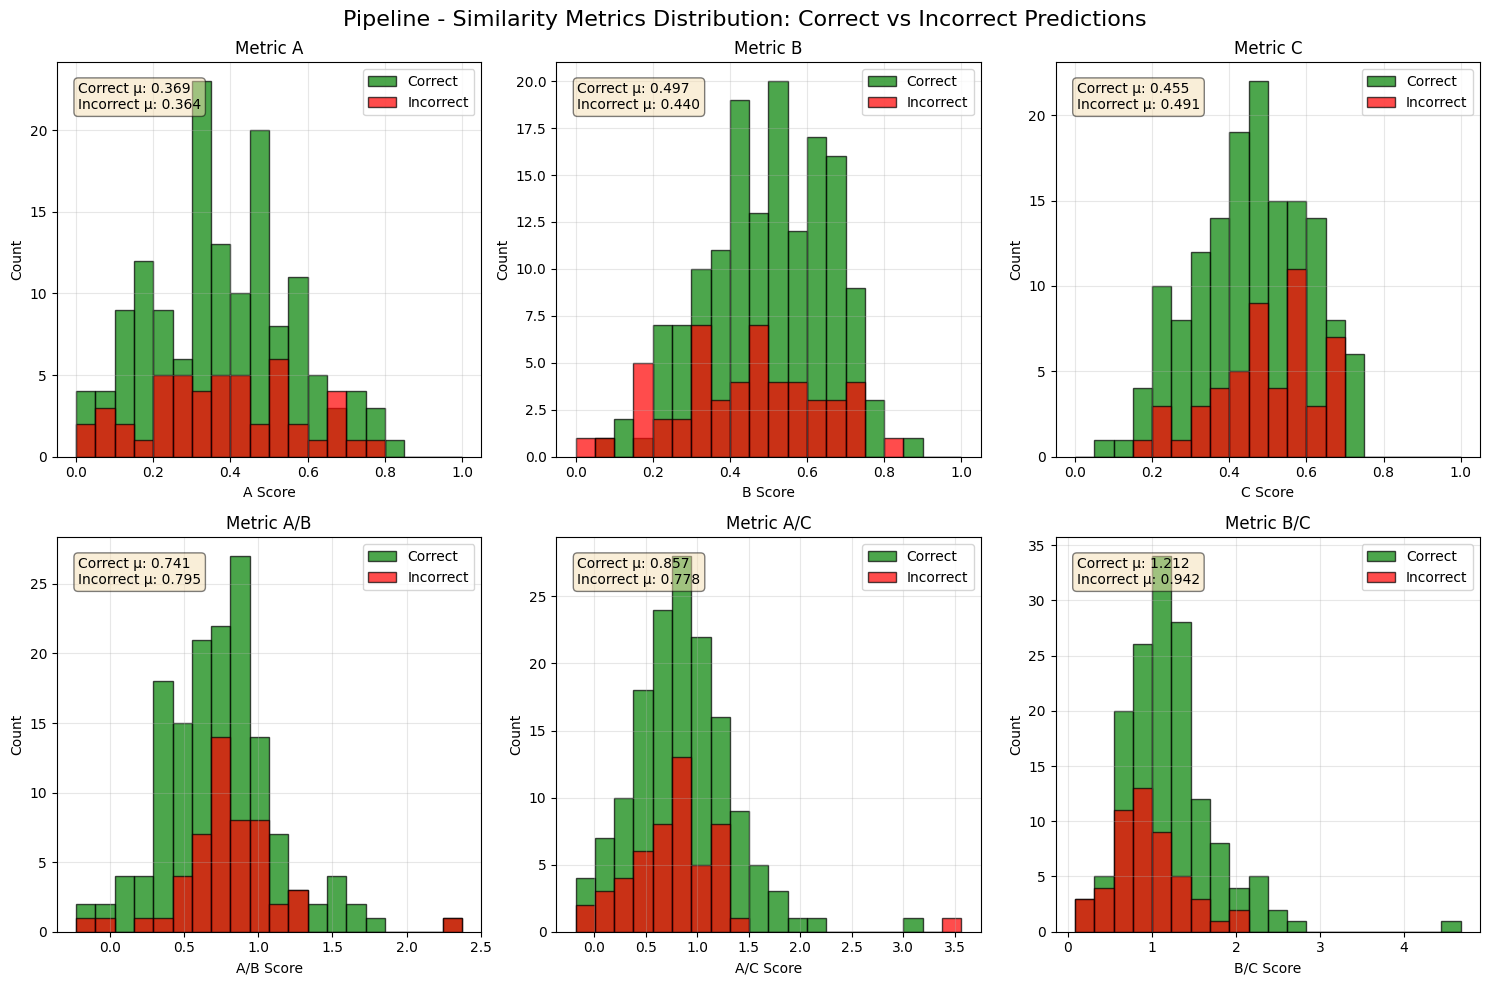

In [ ]:
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()

### Observations 



#### Accuracy:

Joint CoT: 0.735

Pipeline: 0.745



#### Probable Ranges of Scores for Correct Label:

##### Joint CoT:

Metric A: 0.0 - 0.6 

Metric B: 0.45 - 0.85

Metric A/B: 0.0 - 1.25

Metric A/C: 0.0 - 1.25


##### Pipeline:

Metric A: 0.1 - 0.85

Metric B: 0.2 - 0.8

Metric A/B: 0.0 - 1.9

Metric B/C: over 0.5


### Adding the Refine Module with Similarity Thresholds

We designed the reward function for the Refine Modules by first performing a statistical analysis on the relationship between different similarity metrics and the performance of the model. We visualized the results using a histogram so that we could fine thresholds which we could use for our Refine Module. The reward function encouraged the model to stay within the thresholds of the where the model performed best. 

In [16]:
def joint_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')
    
    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],     
        example['hypothesis'],  
        reason,
        pred.explanation
    )

    if 0.0 <= similarity_scores['A'] <= 0.6:
        score += 1.0
    if 0.45 <= similarity_scores['B'] <= 0.85:
        score += 1.0
    if 0.0 <= similarity_scores['A/B'] <= 1.25:
        score += 1.0
    if 0.0 <= similarity_scores['A/C'] <= 1.25:
        score += 1.0

    return score

def pipeline_similarity_reward(example, pred: dspy.Prediction) -> float:
    key = (example['premise'], example['hypothesis'])
    reason = REASON_MAP.get(key, '')

    score = 0.0
    similarity_scores = compute_similarity_scores(
        example['premise'],      
        example['hypothesis'],  
        reason, 
        pred.explanation
    )
    
    if 0.1 <= similarity_scores['A'] <= 0.85:
        score += 1
    if 0.2 <= similarity_scores['B'] <= 0.8:
        score += 1
    if 0.0 <= similarity_scores['A/B'] <= 1.9:
        score += 1
    if 0.5 <= similarity_scores['B/C']:
        score += 1.0

    return score


refined_joint = dspy.Refine(
    module=joint_cot, 
    N=3, 
    reward_fn=joint_similarity_reward, 
    threshold=4.0
)

refined_pipeline = dspy.Refine(
    module=pipeline_module, 
    N=3, 
    reward_fn=pipeline_similarity_reward, 
    threshold=4.0
)

### Evaluation with Refine Module

In [ ]:
joint_accuracy, joint_results = evaluate_with_similarity_v2(
    refined_joint, 
    dspy_eval_samples[:200],
    collect_results=True
)
print(f"Refined Joint CoT Accuracy: {joint_accuracy:.3f}")

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Refined Joint CoT Accuracy: 0.755


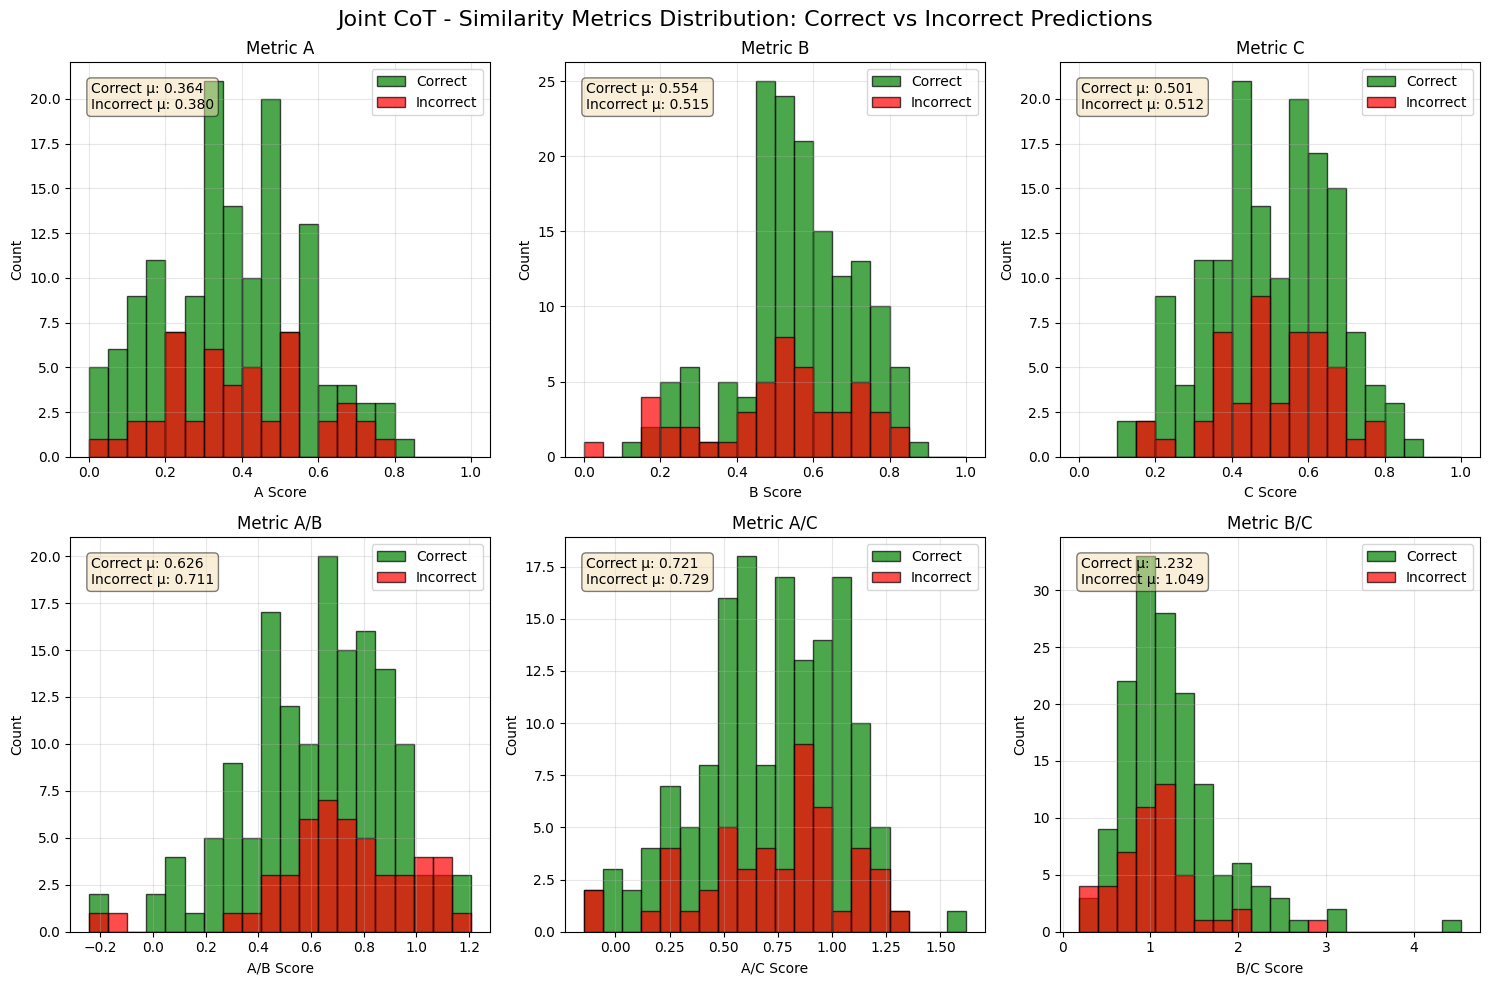

In [88]:
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

### Evaluate with Parallel

In [27]:
joint_accuracy, joint_results = evaluate_with_similarity_parallel(
    refined_joint,
    dspy_eval_samples[:200],
    num_threads=4,  
    collect_results=True
)
print(f"Joint CoT Accuracy: {joint_accuracy:.3f}")

Average Metric: 149.00 / 200 (74.5%): 100%|██████████| 200/200 [08:19<00:00,  2.50s/it]

2025/08/03 13:59:48 INFO dspy.evaluate.evaluate: Average Metric: 149 / 200 (74.5%)



Joint CoT Accuracy: 74.500


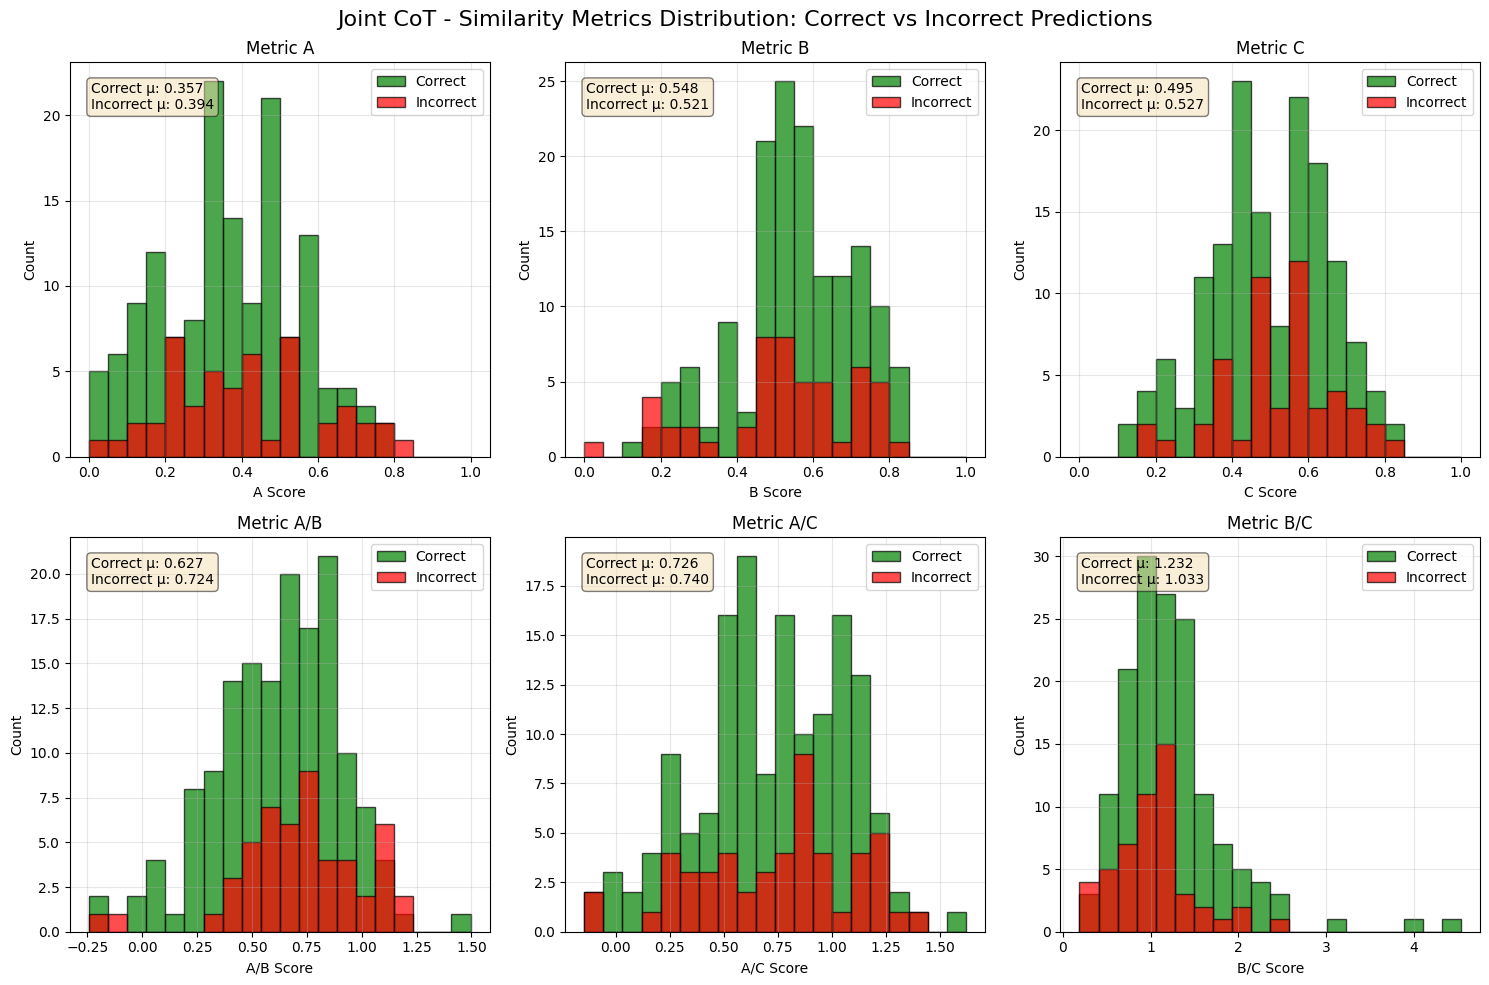

In [39]:
joint_fig = create_similarity_histograms(joint_results, "Joint CoT")
plt.show()

### Refined Pipeline Evaluation

In [93]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity_v2(
    refined_pipeline, 
    dspy_eval_samples[:200],
    collect_results=True
)
print(f"Refined Pipeline Accuracy: {pipeline_accuracy:.3f}")

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Refined Pipeline Accuracy: 0.735


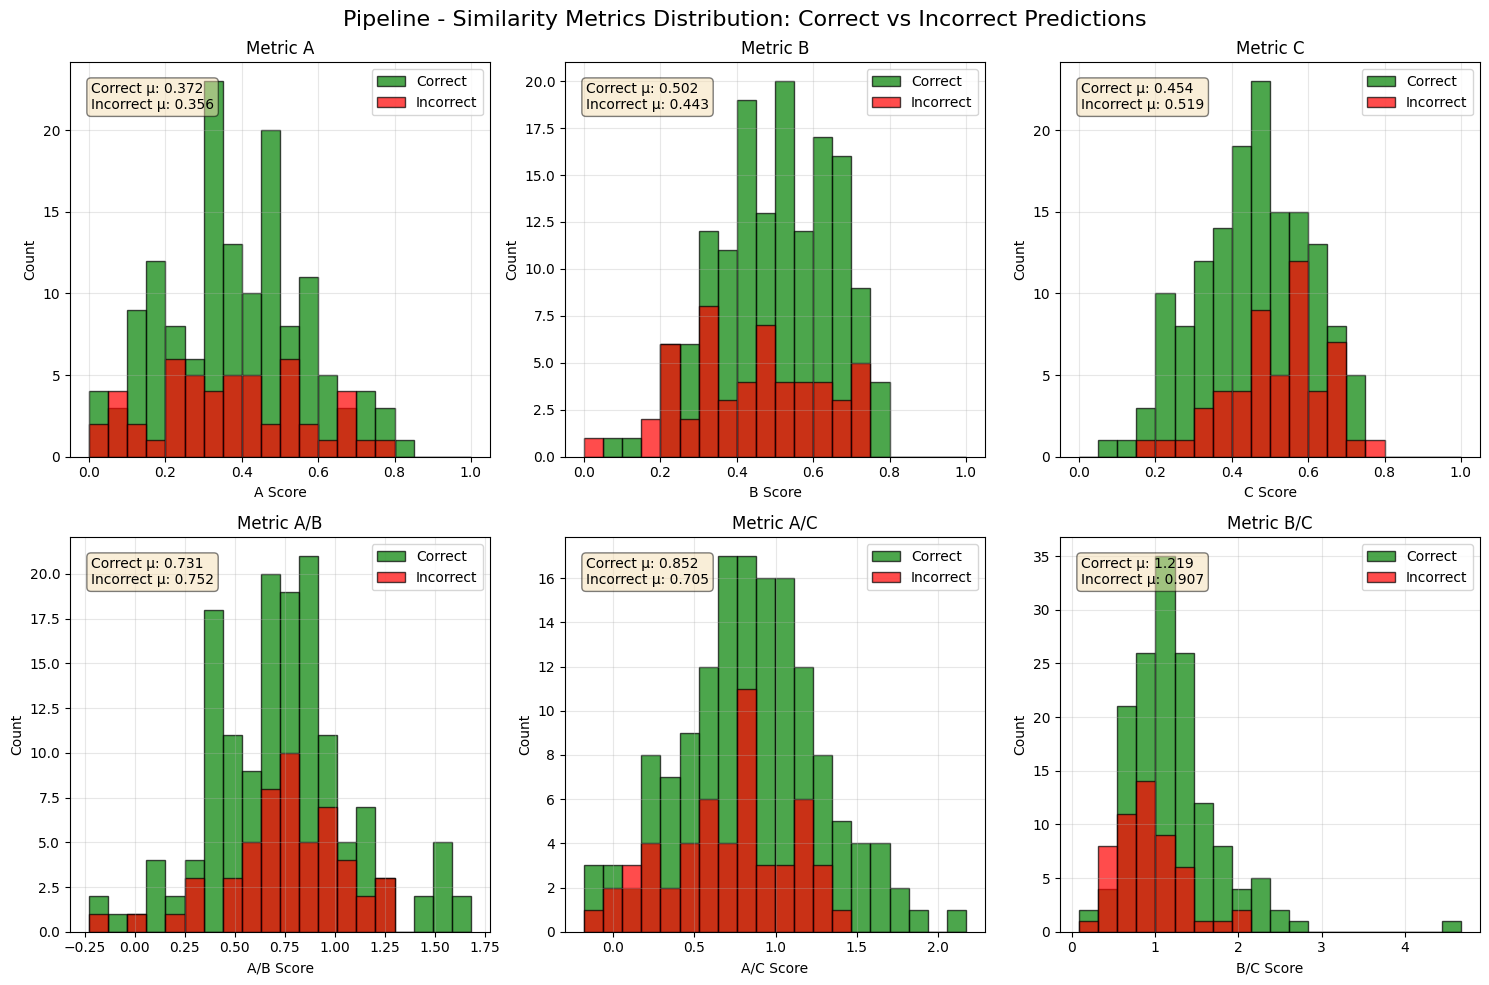

In [95]:
pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()

### Evaluate with Parallel

In [29]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity_parallel(
    refined_pipeline,
    dspy_eval_samples[:200],
    num_threads=8,  
    collect_results=True
)
print(f"Pipeline Module Accuracy: {pipeline_accuracy:.3f}")

Average Metric: 147.00 / 200 (73.5%): 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]

2025/08/03 14:07:18 INFO dspy.evaluate.evaluate: Average Metric: 147 / 200 (73.5%)



Pipeline Module Accuracy: 73.500


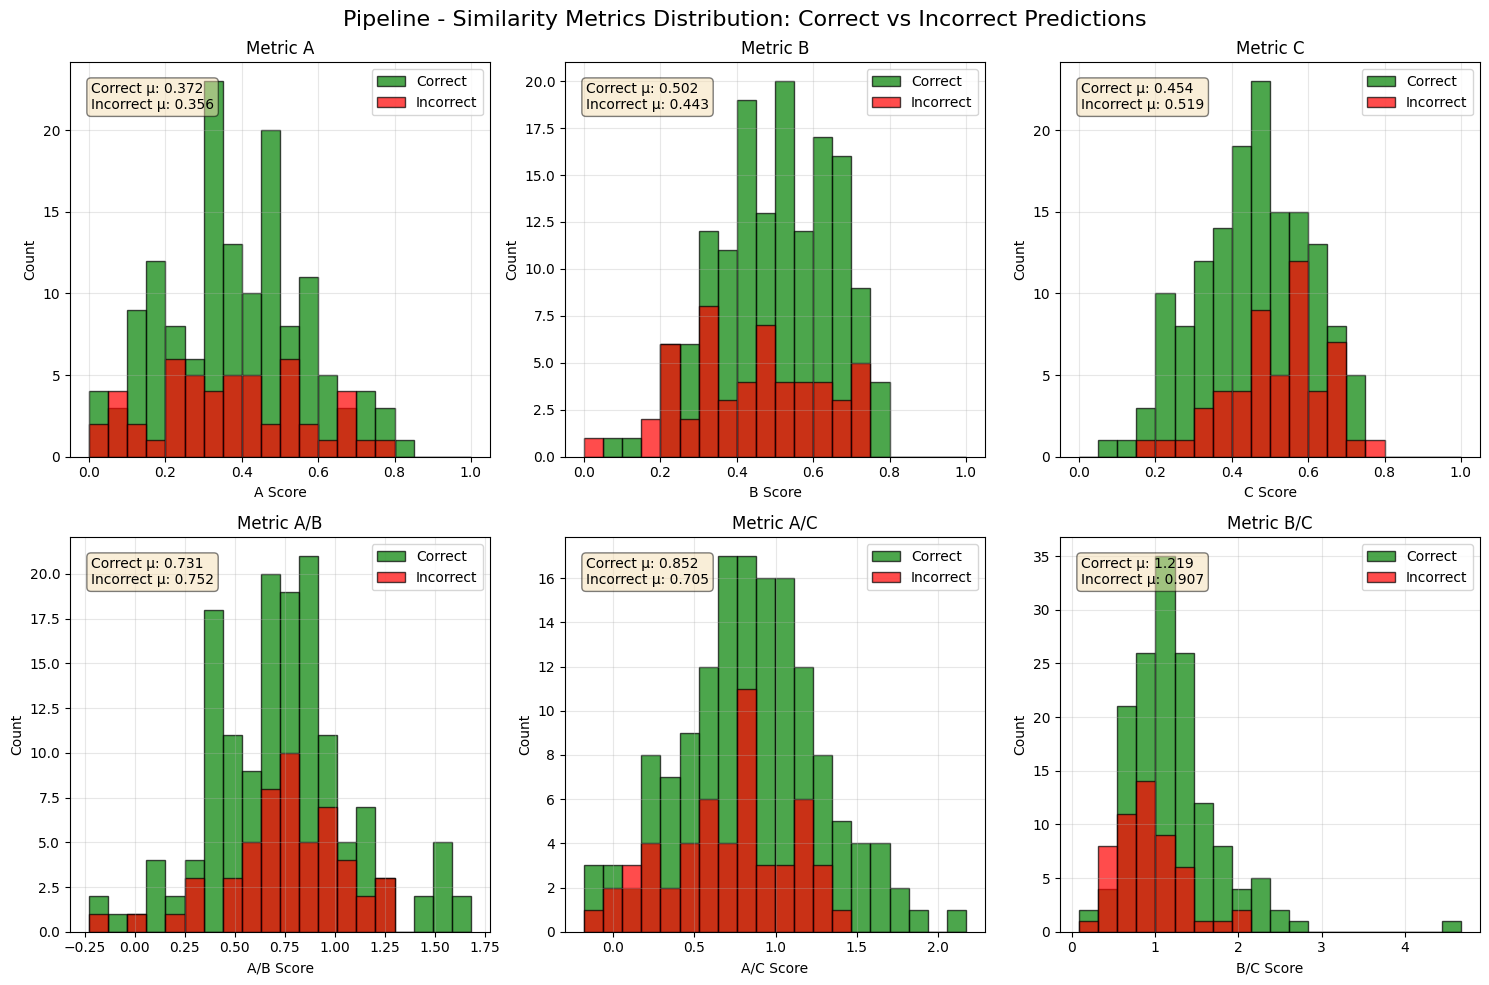

In [40]:
pipeline_fig = create_similarity_histograms(pipeline_results, "Pipeline")
plt.show()

### Refine Module Discussion 

Refined Joint CoT: 

After adding the Refine Module to the Joint CoT Module with the similarity thresholds we found in our analysis, we saw that our accuracy improved from 0.735 to 0.755. 

In [42]:
from dspy import MIPROv2

def exact_match(pred, gold, trace=None):
    try:
        # Create label mappings
        label_names = ["entailment", "neutral", "contradiction"]
        label2id = {label: i for i, label in enumerate(label_names)}
        
        # Extract labels
        pred_label = getattr(pred, 'label', pred)
        gold_label = getattr(gold, 'label', gold)
        
        # Convert pred_label to numeric if it's a string
        if isinstance(pred_label, str):
            pred_label_id = label2id.get(pred_label.strip().lower(), -1)
        else:
            pred_label_id = pred_label
            
        # Convert gold_label to numeric if it's a string
        if isinstance(gold_label, str):
            gold_label_id = label2id.get(gold_label.strip().lower(), -1)
        else:
            gold_label_id = gold_label
            
        return pred_label_id == gold_label_id
        
    except Exception as e:
        print(f"Error in exact_match: {e}, pred={pred_label}, gold={gold_label}")
        return False

optimizer = MIPROv2(metric=exact_match)

In [18]:
optimized_joint = optimizer.compile(
    refined_joint,
    trainset=dspy_eval_samples[:100],
    requires_permission_to_run=False  
)

2025/08/03 12:51:52 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 80

2025/08/03 12:51:52 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/03 12:51:52 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/03 12:51:52 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


 25%|██▌       | 5/20 [00:10<00:31,  2.09s/it]


Bootstrapped 4 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Bootstrapping set 4/6


 20%|██        | 4/20 [00:06<00:27,  1.70s/it]


Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 5/6


 20%|██        | 4/20 [00:07<00:28,  1.81s/it]


Bootstrapped 2 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 6/6


  5%|▌         | 1/20 [00:01<00:34,  1.80s/it]
2025/08/03 12:52:18 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/03 12:52:18 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/03 12:52:18 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...



Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


2025/08/03 12:54:04 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/03 12:54:04 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate both an explanation and a label for the NLI task in one step.

2025/08/03 12:54:04 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are an expert in Natural Language Inference (NLI) tasked with analyzing the relationship between a given premise and hypothesis. Carefully examine the premise and hypothesis to determine if the hypothesis is entailed by, neutral to, or in contradiction with the premise, paying special attention to subtle reasoning errors such as unsupported inferences, overgeneralization, or ambiguous phrasing. 

First, provide a step-by-step reasoning process to break down your analysis. Then, generate a clear and concise explanation of the relationship between the premise and hypothesis. Finally, output the label as one of the following: 'entailment', 'neutral', or 'contradiction'.

Structure your res

Average Metric: 56.00 / 80 (70.0%): 100%|██████████| 80/80 [04:58<00:00,  3.73s/it]

2025/08/03 12:59:02 INFO dspy.evaluate.evaluate: Average Metric: 56 / 80 (70.0%)
2025/08/03 12:59:02 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 70.0



/Users/yuval/University/Semester 6/NLP_w_LLMs/hw2/nlp-with-llms-2025-hw2/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/08/03 12:59:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [02:01<00:00,  3.47s/it]

2025/08/03 13:01:05 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/08/03 13:01:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/03 13:01:05 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14]
2025/08/03 13:01:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 13:01:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:01:05 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 13:01:05 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==



Average Metric: 19.00 / 35 (54.3%): 100%|██████████| 35/35 [02:34<00:00,  4.41s/it]

2025/08/03 13:03:39 INFO dspy.evaluate.evaluate: Average Metric: 19 / 35 (54.3%)
2025/08/03 13:03:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/03 13:03:39 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29]
2025/08/03 13:03:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 13:03:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:03:39 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 13:03:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==



Average Metric: 22.00 / 35 (62.9%): 100%|██████████| 35/35 [02:00<00:00,  3.46s/it]

2025/08/03 13:05:40 INFO dspy.evaluate.evaluate: Average Metric: 22 / 35 (62.9%)
2025/08/03 13:05:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/08/03 13:05:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86]
2025/08/03 13:05:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 13:05:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:05:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 13:05:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==



Average Metric: 27.00 / 35 (77.1%): 100%|██████████| 35/35 [02:33<00:00,  4.38s/it]

2025/08/03 13:08:15 INFO dspy.evaluate.evaluate: Average Metric: 27 / 35 (77.1%)
2025/08/03 13:08:15 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/08/03 13:08:15 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86, 77.14]
2025/08/03 13:08:15 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 13:08:15 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:08:15 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 13:08:15 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [00:28<00:00,  1.24it/s]

2025/08/03 13:08:43 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/03 13:08:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/08/03 13:08:43 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86, 77.14, 65.71]
2025/08/03 13:08:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0]
2025/08/03 13:08:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:08:43 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 13:08:43 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/08/03 13:08:43 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 77.14) from minibatch trials...



Average Metric: 56.00 / 80 (70.0%): 100%|██████████| 80/80 [03:01<00:00,  2.27s/it]

2025/08/03 13:11:45 INFO dspy.evaluate.evaluate: Average Metric: 56 / 80 (70.0%)
2025/08/03 13:11:45 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 70.0]
2025/08/03 13:11:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:11:45 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/03 13:11:45 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/03 13:11:45 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==



Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [01:53<00:00,  3.23s/it]

2025/08/03 13:13:39 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)
2025/08/03 13:13:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/08/03 13:13:39 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86, 77.14, 65.71, 60.0]
2025/08/03 13:13:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 70.0]
2025/08/03 13:13:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:13:39 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 13:13:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==



Average Metric: 23.00 / 35 (65.7%): 100%|██████████| 35/35 [02:44<00:00,  4.69s/it]

2025/08/03 13:16:23 INFO dspy.evaluate.evaluate: Average Metric: 23 / 35 (65.7%)
2025/08/03 13:16:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/08/03 13:16:23 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86, 77.14, 65.71, 60.0, 65.71]
2025/08/03 13:16:23 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 70.0]
2025/08/03 13:16:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:16:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/08/03 13:16:23 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [02:27<00:00,  4.20s/it]

2025/08/03 13:18:51 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)
2025/08/03 13:18:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/08/03 13:18:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86, 77.14, 65.71, 60.0, 65.71, 68.57]
2025/08/03 13:18:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 70.0]
2025/08/03 13:18:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:18:51 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/03 13:18:51 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==



Average Metric: 28.00 / 35 (80.0%): 100%|██████████| 35/35 [00:22<00:00,  1.58it/s]

2025/08/03 13:19:14 INFO dspy.evaluate.evaluate: Average Metric: 28 / 35 (80.0%)
2025/08/03 13:19:14 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/03 13:19:14 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86, 77.14, 65.71, 60.0, 65.71, 68.57, 80.0]
2025/08/03 13:19:14 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 70.0]
2025/08/03 13:19:14 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:19:14 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/03 13:19:14 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==



Average Metric: 24.00 / 35 (68.6%): 100%|██████████| 35/35 [00:36<00:00,  1.03s/it]

2025/08/03 13:19:50 INFO dspy.evaluate.evaluate: Average Metric: 24 / 35 (68.6%)


2025/08/03 13:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/08/03 13:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 62.86, 77.14, 65.71, 60.0, 65.71, 68.57, 80.0, 68.57]
2025/08/03 13:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 70.0]
2025/08/03 13:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 70.0
2025/08/03 13:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/08/03 13:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/08/03 13:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 77.14) from minibatch trials...


Average Metric: 58.00 / 80 (72.5%): 100%|██████████| 80/80 [03:18<00:00,  2.48s/it]

2025/08/03 13:23:11 INFO dspy.evaluate.evaluate: Average Metric: 58 / 80 (72.5%)
2025/08/03 13:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 72.5


2025/08/03 13:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [70.0, 70.0, 72.5]
2025/08/03 13:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 72.5
2025/08/03 13:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/08/03 13:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/08/03 13:23:11 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 72.5!


In [45]:
def exact_match(pred, gold, trace=None):
    try:
        # Create label mappings
        label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
        
        # Get predicted label
        pred_label = pred.label if hasattr(pred, 'label') else str(pred)
        
        # Convert to numeric if string
        if isinstance(pred_label, str):
            pred_label_id = label2id.get(pred_label.strip().lower(), -1)
        else:
            pred_label_id = pred_label
            
        # Gold label should already be numeric in your dataset
        gold_label_id = gold.label if hasattr(gold, 'label') else gold
            
        return pred_label_id == gold_label_id
        
    except Exception as e:
        print(f"Error in exact_match: {e}")
        return False

In [47]:
optimizer = MIPROv2(
    metric=exact_match,
    num_threads=4,
)

optimized_joint = optimizer.compile(
    refined_joint,
    trainset=dspy_eval_samples[:100],
    requires_permission_to_run=False,
)

2025/08/03 14:22:56 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 80

2025/08/03 14:22:56 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/08/03 14:22:56 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/08/03 14:22:56 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


Average Metric: 5.00 / 6 (83.3%):  17%|█▋        | 6/35 [06:16<30:19, 62.76s/it]


100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Bootstrapped 0 full traces after 19 examples for up to 1 rounds, amounting to 20 attempts.
Bootstrapping set 4/6


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Bootstrapped 0 full traces after 19 examples for up to 1 rounds, amounting to 20 attempts.
Bootstrapping set 5/6


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Bootstrapped 0 full traces after 19 examples for up to 1 rounds, amounting to 20 attempts.
Bootstrapping set 6/6


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
2025/08/03 14:24:18 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/08/03 14:24:18 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/08/03 14:24:18 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/08/03 14:24:18 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/08/03 14:24:18 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Generate both an explanation and a label for the NLI task in one step.

2025/08/03 14:24:18 INFO dspy.teleprompt.mipro_optimizer_v2: 1: For each provided premise and hypothesis from the dataset, which focuses on non-entailment cases (always labeled as 0) involving topics like politics, sports, and crime, generate a clear and detailed explana

Bootstrapped 0 full traces after 19 examples for up to 1 rounds, amounting to 20 attempts.
Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.
  0%|          | 0/80 [00:00<?, ?it/s]

2025/08/03 14:26:02 WARNING dspy.utils.parallelizer: SIGINT received. Cancelling.


KeyboardInterrupt: 

In [ ]:
# After optimization completes
print("Evaluating optimized model...")
opt_accuracy, opt_results = evaluate_with_similarity_parallel(
    optimized_joint,
    dspy_eval_samples[100:300],  # Use different data for testing
    num_threads=4,
    collect_results=True
)
print(f"Optimized Joint CoT Accuracy: {opt_accuracy:.3f}")

# Visualize results
opt_fig = create_similarity_histograms(opt_results, "Optimized Joint CoT")
plt.show()

In [ ]:
joint_accuracy, joint_results = evaluate_with_similarity_v2(
    optimized_joint, 
    dspy_eval_samples[:200], 
    collect_results=True
)
print(f"Optimized Joint CoT Accuracy: {joint_accuracy:.3f}")

In [ ]:
optimized_pipeline = optimizer.compile(
    refined_pipeline,
    trainset=dspy_eval_samples[:100],
    requires_permission_to_run=False  
)

In [ ]:
pipeline_accuracy, pipeline_results = evaluate_with_similarity_v2(
    optimized_pipeline, 
    dspy_eval_samples[:200],  
    collect_results=True
)
print(f"Optimized Pipeline Accuracy: {pipeline_accuracy:.3f}")

In [ ]:
joint_accuracy, joint_results = evaluate_with_similarity_v2(
    refined_joint, 
    dspy_eval_samples[207:209],  
    collect_results=True
)
print(f"Refined Joint CoT Accuracy: {joint_accuracy:.3f}")

In [19]:
import time
from dspy.evaluate import Evaluate

# First, let's create a wrapper to make your evaluation compatible with dspy.Evaluate
def create_evaluator_metric(module, collect_similarity=False):
    """Create a metric function compatible with dspy.Evaluate"""
    LABEL_MAP = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    results_collector = [] if collect_similarity else None
    
    def metric(example, prediction, trace=None):
        # Handle the case where prediction might be the module output
        if hasattr(prediction, 'label'):
            pred_label = prediction.label
            pred_explanation = prediction.explanation
        else:
            # If not, run the module
            pred = module(premise=example.premise, hypothesis=example.hypothesis)
            pred_label = pred.label
            pred_explanation = pred.explanation
        
        # Convert labels
        pred_label_int = LABEL_MAP.get(pred_label.lower().strip(), -1)
        true_label = example.label
        
        is_correct = pred_label_int == true_label
        
        # Collect similarity scores if requested
        if collect_similarity and hasattr(example, 'reason') and example.reason:
            sim_scores = compute_similarity_scores(
                premise=example.premise,
                hypothesis=example.hypothesis,
                human_reason=example.reason,
                predicted_explanation=pred_explanation
            )
            results_collector.append({
                'premise': example.premise,
                'hypothesis': example.hypothesis,
                'true_label': true_label,
                'predicted_label': pred_label,
                'human_reason': example.reason,
                'predicted_explanation': pred_explanation,
                'is_correct': is_correct,
                **sim_scores
            })
        
        return is_correct
    
    return metric, results_collector

# Test comparison: Sequential vs Parallel evaluation
print("Testing evaluation speed comparison...")

# Take a subset for testing
test_subset = dspy_eval_samples[:50]

# 1. Time your current sequential approach
print("\n1. Sequential Evaluation (current approach):")
start_time = time.time()
seq_accuracy, seq_results = evaluate_with_similarity_v2(
    joint_cot, 
    test_subset,
    collect_results=True
)
seq_time = time.time() - start_time
print(f"Sequential time: {seq_time:.2f}s, Accuracy: {seq_accuracy:.3f}")

# 2. Time the parallel approach with dspy.Evaluate
print("\n2. Parallel Evaluation (dspy.Evaluate):")
start_time = time.time()

# Create the metric and results collector
metric_fn, results_collector = create_evaluator_metric(joint_cot, collect_similarity=True)

# Create and run the evaluator
evaluator = Evaluate(
    devset=test_subset,
    metric=metric_fn,
    num_threads=4,  # Adjust based on your API rate limits
    display_progress=True,
    display_table=0  # Don't display the full table
)

parallel_accuracy = evaluator(joint_cot)
parallel_time = time.time() - start_time
print(f"Parallel time: {parallel_time:.2f}s, Accuracy: {parallel_accuracy:.3f}")

print(f"\nSpeedup: {seq_time/parallel_time:.2f}x faster")
print(f"Results collected: {len(results_collector)} examples")

Testing evaluation speed comparison...

1. Sequential Evaluation (current approach):


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Sequential time: 18.70s, Accuracy: 0.600

2. Parallel Evaluation (dspy.Evaluate):
Average Metric: 30.00 / 50 (60.0%): 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]

2025/08/03 13:36:02 INFO dspy.evaluate.evaluate: Average Metric: 30 / 50 (60.0%)



Parallel time: 13.36s, Accuracy: 60.000

Speedup: 1.40x faster
Results collected: 50 examples
